### Importing Required Libraries 

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import os
from tqdm.notebook import tqdm
from gensim.models import FastText
from gensim.models import Word2Vec

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kianathakkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### We will use Word2Vec, Fastext and BERT for creating word embeddings

In [3]:
print(os.getcwd())

/Users/kianathakkar/Documents/NlpProductReco/notebook


In [4]:
# Specify the folder path where your CSV files are located
folder_path = "/Users/kianathakkar/Documents/dataset/Bigbasket/BigBasket_Data.csv"

df = pd.read_csv(folder_path)

In [5]:
df.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,"This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholest..."
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), refrigerator safe, dishwasher safe and can also be..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your mother, sister, in-laws, boss or your friends, this..."
3,4,Cereal Flip Lid Container/Storage Jar - Assorted Colour,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive design and made from food-grade plastic for your hygie...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best care that it must get. The soft bar consists of V...


In [6]:
df = df.drop_duplicates()

In [7]:
# Preprocessing: Combine columns into 'Description'
df['combined_text'] = df['product'] + ' ' + df['category'] + ' ' + df['sub_category'] + ' ' + df['brand']+ ' ' + df['type']
# + '' + df['description']

In [8]:
df = df.dropna()

### Preprocessing Text To Remove stop words,punctuation etc

In [9]:
def remove_special_characters(text):
    # Use regex to remove all non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()

    return text

def remove_stop_words(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(words)

In [10]:
df['combined_text'] = df['combined_text'].apply(remove_special_characters)
df['combined_text'] = df['combined_text'].apply(remove_stop_words)

In [11]:
df['length'] = df['combined_text'].str.len()

### Visualising sentence length distribution to decide max_length for BERT

In [12]:
df['word_count'] = df['combined_text'].apply(lambda x: len(x.split()))

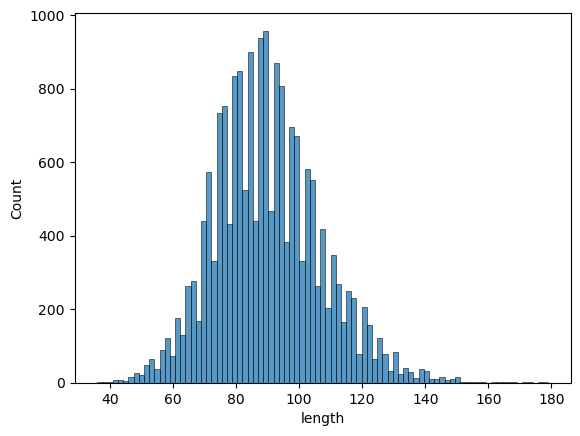

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(x=df['length'])
plt.show()

### Getting vocab size for the combined text

In [14]:
# Create an empty set to store unique words
unique_words = set()

# Tokenize the text and add unique words to the set
for text in df['combined_text']:
    words = text.split()  # Split text into words
    unique_words.update(words)  # Add unique words to the set

# Calculate the vocabulary size (number of unique words)
vocab_size = len(unique_words)

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9911


In [15]:
df.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description,combined_text,length,word_count
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,"This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholest...",garlic oil vegetarian capsule 500 mg beauty hygiene hair care sri sri ayurveda hair oil serum,93,16
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), refrigerator safe, dishwasher safe and can also be...",water bottle orange kitchen garden pets storage accessories mastercook water fridge bottles,91,12
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your mother, sister, in-laws, boss or your friends, this...",brass angle deep plain no2 cleaning household pooja needs trm lamp lamp oil,75,13
3,4,Cereal Flip Lid Container/Storage Jar - Assorted Colour,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive design and made from food-grade plastic for your hygie...,cereal flip lid containerstorage jar assorted colour cleaning household bins bathroom ware nakod...,121,16
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best care that it must get. The soft bar consists of V...,creme soft soap hands body beauty hygiene bath hand wash nivea bathing bars soaps,81,14


In [16]:
# Word2Vec implementation
sentences = [text.split() for text in df['combined_text']]
model_wordtovec = Word2Vec(sentences, vector_size=200, window=20, min_count=1, sg=0,alpha=0.05, epochs=100, negative=5) 

In [64]:
# Model using FastText
model_fastext = FastText(sentences, vector_size=200, window=20, min_count=1, sg=0,epochs=100)

In [56]:
def get_similarity_fastext(model,user_query):
    
    user_query = remove_special_characters(user_query)
    user_query = remove_stop_words(user_query)

    # Convert the query to a FastText vector
    query_vector = model.wv[user_query]

    # Calculate the cosine similarity between the query and the product name description sentence vectors
    cosine_similarity_scores = []
    
    for product_name_description_sentence in df['combined_text']:

        # Convert the product name description sentence to a FastText vector
        product_name_description_sentence_vector = model.wv[product_name_description_sentence]

        # Calculate the cosine similarity between the query and the product name description sentence vectors
        cosine_similarity_score = np.dot(query_vector, product_name_description_sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(product_name_description_sentence_vector))

        # Save the cosine similarity score to the list
        cosine_similarity_scores.append(cosine_similarity_score)

    return cosine_similarity_scores
    

In [57]:
def get_similarity_word2vec(model,user_query):
    
    user_query = remove_special_characters(user_query)
    user_query = remove_stop_words(user_query)

    # Convert the query to a FastText vector
    query_vector = model.wv[user_query.split()].mean(axis=0)

    # Calculate the cosine similarity between the query and the product name description sentence vectors
    cosine_similarity_scores = []
    
    for product_name_description_sentence in df['combined_text']:

        # Convert the product name description sentence to a FastText vector
        product_name_description_sentence_vector = model.wv[product_name_description_sentence.split()].mean(axis=0)

        # Calculate the cosine similarity between the query and the product name description sentence vectors
        cosine_similarity_score = np.dot(query_vector, product_name_description_sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(product_name_description_sentence_vector))

        # Save the cosine similarity score to the list
        cosine_similarity_scores.append(cosine_similarity_score)

    return cosine_similarity_scores
    

In [71]:
#User query
user_query = 'disinfectant toilet cleaner'

In [72]:
# Calculate the cosine similarity scores using fastext
df['cosine_similarity_fastext'] = get_similarity_fastext(model_fastext, user_query)

# Sort products by similarity and select the top 10
print(df.nlargest(20, 'cosine_similarity_fastext'))

       index  \
22159  22160   
23967  23968   
6832    6833   
6861    6862   
22162  22163   
25126  25127   
21532  21533   
25758  25759   
24422  24423   
1270    1271   
6004    6005   
19591  19592   
11945  11946   
2445    2446   
901      902   
21944  21945   
7111    7112   
7437    7438   
12156  12157   
3191    3192   

                                                                                product  \
22159                                                    Toilet Seat Disinfectant Spray   
23967                                 Liquid Disinfectant Cleaner for Home - Lime Fresh   
6832                                 Disinfectant Toilet Cleaner - White & Shine Bleach   
6861                                          Disinfectant Toilet Cleaner Liquid - Rose   
22162                                         Disinfectant Toilet Cleaner Liquid - Rose   
25126                                       Disinfectant Toilet Cleaner Liquid - Orange   
21532                  Ger

In [73]:
# Calculate the cosine similarity scores using wordtovec
df['cosine_similarity_wordtovec'] = get_similarity_word2vec(model_wordtovec, user_query)

print(df.nlargest(20, 'cosine_similarity_wordtovec'))

       index  \
19591  19592   
11945  11946   
25758  25759   
25126  25127   
24422  24423   
21532  21533   
1270    1271   
6832    6833   
6861    6862   
22162  22163   
22633  22634   
2378    2379   
20577  20578   
12156  12157   
11054  11055   
7111    7112   
7437    7438   
14876  14877   
19266  19267   
9451    9452   

                                                                                product  \
19591  Harpic Disinfectant Toilet Cleaner Original200ml+Lizol Floor Cleaner Citrus200ml   
11945                                            Power Plus Disinfectant Toilet Cleaner   
25758                Platinum Active-Shield Disinfectant Toilet Cleaner Liquid - Marine   
25126                                       Disinfectant Toilet Cleaner Liquid - Orange   
24422                                       Original Disinfectant Toilet Cleaner Liquid   
21532                  Germ & Stain Blaster Disinfectant Toilet Cleaner Liquid - Floral   
1270               Platinu

In [23]:
!pip install sentence_transformers

In [24]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-uncased')

product_embeddings = model.encode(df['combined_text'].tolist())

No sentence-transformers model found with name /Users/kianathakkar/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/kianathakkar/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

In [25]:
product_embeddings.shape

(18840, 768)

In [28]:
import pickle

# Save the product embeddings to a file (e.g., a Pickle file)
with open('product_embeddings_bert_sent.pkl', 'wb') as file:
    pickle.dump(product_embeddings, file)

In [37]:
query_bert = "premium filter coffee"

query_bert = remove_special_characters(query_bert)
query_bert = remove_stop_words(query_bert)

query_embedding = model.encode(query_bert)

cosine_similarity_scores_bert = []

for product_embedding in product_embeddings:
    cosine_similarity_score = np.dot(query_embedding, product_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(product_embedding))
    cosine_similarity_scores_bert.append(cosine_similarity_score)

df['cosine_similarity_bert'] = cosine_similarity_scores_bert

In [38]:
print(df.nlargest(20, 'cosine_similarity_bert'))

       index                                           product   category  \
11200  11201                        Fresh Strong Filter Coffee  Beverages   
15173  15174                                    Classic Coffee  Beverages   
25050  25051                       Fresh Intense Filter Coffee  Beverages   
21022  21023                                    Premium Coffee  Beverages   
7350    7351                            Coffee - Eighty Degree  Beverages   
26239  26240                                     Strong Coffee  Beverages   
8050    8051                                     Strong Coffee  Beverages   
10645  10646                                 Xtra Coffee Pouch  Beverages   
6271    6272                                     3-In-1 Coffee  Beverages   
18869  18870               Traditional Filter Coffee Decoction  Beverages   
20065  20066               Traditional Filter Coffee Decoction  Beverages   
25367  25368                     Organic Coffee - Powder, Bold  Beverages   